In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers import Normalization, Dense, InputLayer
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Data Preparation

In [2]:
data = pd.read_csv("train.csv")
print(data)

     v.id  on road old  on road now  years      km  rating  condition  \
0       1       535651       798186      3   78945       1          2   
1       2       591911       861056      6  117220       5          9   
2       3       686990       770762      2  132538       2          8   
3       4       573999       722381      4  101065       4          3   
4       5       691388       811335      6   61559       3          9   
..    ...          ...          ...    ...     ...     ...        ...   
995   996       633238       743850      5  125092       1          6   
996   997       599626       848195      4   83370       2          9   
997   998       646344       842733      7   86722       1          8   
998   999       535559       732439      2  140478       4          5   
999  1000       590105       779743      5   67295       4          2   

     economy  top speed   hp  torque  current price  
0         14        177   73     123       351318.0  
1          9   

In [3]:
# sns.pairplot(data[['on road old', 'on road now', 'years', 'km', 'rating', 'condition', 'economy', 'top speed', 'hp', 'torque', 'current price']])

# Converting our Data into a Tensor

In [4]:
tensor_data = tf.constant(data)
tensor_data = tf.cast(tensor_data, tf.float32)
print(tensor_data)

tf.Tensor(
[[1.000000e+00 5.356510e+05 7.981860e+05 ... 7.300000e+01 1.230000e+02
  3.513180e+05]
 [2.000000e+00 5.919110e+05 8.610560e+05 ... 7.400000e+01 9.500000e+01
  2.850015e+05]
 [3.000000e+00 6.869900e+05 7.707620e+05 ... 5.300000e+01 9.700000e+01
  2.153860e+05]
 ...
 [9.980000e+02 6.463440e+05 8.427330e+05 ... 1.130000e+02 8.900000e+01
  4.058710e+05]
 [9.990000e+02 5.355590e+05 7.324390e+05 ... 1.120000e+02 1.280000e+02
  7.439800e+04]
 [1.000000e+03 5.901050e+05 7.797430e+05 ... 9.900000e+01 9.600000e+01
  4.149385e+05]], shape=(1000, 12), dtype=float32)


In [5]:
tensor_data = tf.random.shuffle(tensor_data)
print(tensor_data[:5])

tf.Tensor(
[[5.420000e+02 5.095600e+05 8.984760e+05 7.000000e+00 9.706100e+04
  4.000000e+00 3.000000e+00 8.000000e+00 1.760000e+02 1.180000e+02
  7.500000e+01 3.082205e+05]
 [9.610000e+02 5.468070e+05 8.067200e+05 6.000000e+00 9.704400e+04
  3.000000e+00 9.000000e+00 1.100000e+01 1.770000e+02 8.300000e+01
  8.100000e+01 3.145765e+05]
 [6.740000e+02 6.878190e+05 8.158960e+05 7.000000e+00 6.399300e+04
  3.000000e+00 9.000000e+00 1.200000e+01 1.480000e+02 7.400000e+01
  1.100000e+02 5.173660e+05]
 [5.340000e+02 6.292540e+05 8.705860e+05 7.000000e+00 8.352400e+04
  2.000000e+00 8.000000e+00 1.300000e+01 1.940000e+02 9.700000e+01
  1.140000e+02 4.241075e+05]
 [4.470000e+02 5.445930e+05 8.745320e+05 2.000000e+00 1.094530e+05
  5.000000e+00 4.000000e+00 1.300000e+01 1.590000e+02 9.900000e+01
  1.050000e+02 2.740750e+05]], shape=(5, 12), dtype=float32)


In [6]:
x = tensor_data[:, 3:-1]
x.shape

TensorShape([1000, 8])

# We expand the dimensions by 1 which makes our 1d tensor now have 1000 rows and 1 column

In [7]:
y = tensor_data[:, -1]
y = tf.expand_dims(y, axis = -1)
print(y[:5])

tf.Tensor(
[[308220.5]
 [314576.5]
 [517366. ]
 [424107.5]
 [274075. ]], shape=(5, 1), dtype=float32)


# We have to split our data into train, test and validation ratio. So that we can see how fine our model is doing on data it was not trained on

In [8]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
DATASET_SIZE = len(x)

In [9]:
X_train = x[:int(DATASET_SIZE*TRAIN_RATIO)]
y_train = y[:int(DATASET_SIZE*TRAIN_RATIO)]
print(X_train.shape)

(800, 8)


# The tf.data.Dataset can help loading our model even faster and more efficiently
NOTE: when working with a dataset of say a thousand elements, we wouldnt see or clearly notice the advantage of using this data API but as our dataset gets latger, it becomes very important to master how to use this API

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [11]:
# for x,y in train_dataset:
#   print(x,y)
#   break

In [12]:
X_val = x[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
y_val = y[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
print(X_val.shape)

(100, 8)


In [13]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [14]:
X_test = x[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO+TEST_RATIO))]
y_test = y[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
print(X_test.shape)
print(y_test.shape)

(100, 8)
(100, 1)


In [15]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

# Scaling our data which is the same as Normalizing the data
we have to avoid information leaking from our training data to the other data so we have to normalize only the train data

In [16]:
# normalizer = Normalization(mean=5, variance=4)
# instead of the above, we can let tensorflow get the mean and variance for us in each axis
normalizer = Normalization()
# x_normalized = tf.constant([[2,4,5,6,7], [4,5,6,7,8]])

normalizer.adapt(X_train)
normalizer(X_train)

<tf.Tensor: shape=(800, 8), dtype=float32, numpy=
array([[ 1.4092883 , -0.12211128,  0.70273787, ...,  0.49410382,
         1.6266226 , -1.3346272 ],
       [ 0.83082205, -0.12269122, -0.01251673, ...,  0.5455863 ,
        -0.09356584, -1.0525889 ],
       [ 1.4092883 , -1.2502147 , -0.01251673, ..., -0.9474049 ,
        -0.5359    ,  0.31059554],
       ...,
       [ 0.83082205, -0.00820244, -1.443026  , ...,  1.4722705 ,
         1.5774742 , -0.7705508 ],
       [ 0.83082205, -1.3332497 , -0.01251673, ..., -0.32961544,
        -1.568013  ,  0.07556371],
       [-0.3261105 ,  0.7983362 , -0.7277713 , ..., -1.4107469 ,
        -1.568013  ,  0.78065914]], dtype=float32)>

# Creating our Model (Linear Regression)

In [17]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (8,)),
    normalizer,
    Dense(128, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 8)                 17        
 on)                                                             
                                                                 
 dense (Dense)               (None, 128)               1152      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34322 (134.07 KB)
Trainable params: 34305 (134.00 KB)
Non-trainable params: 17 (72.00 Byte)
________________

# We can also write our model by adding its parameters

In [18]:
# model = tf.keras.Sequential()
# model.add(normalizer)
# model.add(Dense(1))

# model.summary()

# Plotting our model

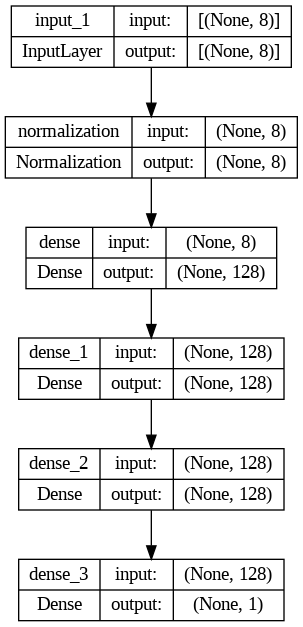

In [19]:
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes=True)

# We can not pass in our data into our model at once as it can cause over treating, we pass it in batches for great memory control and great treatment. Batches of 32 and below is actually a good idea.

In [20]:
# model = tf.keras.Sequential()
# # the first axis of the  input_shape is our batch size,
# # if we xo not know our batch size yet, we can leave it
# model.add(InputLayer(input_shape = (8,)))
# model.add(normalizer)
# model.add(Dense(1))

# model.summary()

In [21]:
# tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes=True)

# Error Sanctioning
We sanction the model anytime the model prediction differs from the original output, when the error is reduced, our model receives less sanctioning. WHen it is perfect, our model receives no sanctioning

## For regressions tasks, apart from the mean squared error, we also have the mean absolute error
When we have an outlier, we use the mean absolute error, when we have a normal point, we use the mean squared error
A normal data point we mean a point where the Y true - Ypred is less than a given threshold.
An outlier would be a point where the Ytrue - Ypred is greater than this certain threshold.

# A slower learning rate gives us more accuracy

In [22]:
model.compile(optimizer = Adam(learning_rate = 0.1),
              loss = MeanAbsoluteError(),
              metrics = RootMeanSquaredError())

#if we specify a learning rate of 1 for our optimizer, we would see that the losses drop faster
# model.compile(optimizer = Adam(learning_rate = 1), loss = MeanAbsoluteError())

# The epoch in the below is the number of times we are going to update our weight, the number of time we are going to optimize out output to get a more accurate result
# Because our verbose is 1, we will see in real time the values of our optimizer **kwargs, we are able to get the kind of output below

In [23]:
history = model.fit(train_dataset, validation_data = val_dataset, epochs = 100, verbose = 1)

Epoch 1/100
25/25 [==============================] - 2s 11ms/step - loss: 145011.2812 - root_mean_squared_error: 196943.8906 - val_loss: 53566.7461 - val_root_mean_squared_error: 65958.7422
Epoch 2/100
25/25 [==============================] - 0s 4ms/step - loss: 45824.2969 - root_mean_squared_error: 56722.0547 - val_loss: 41221.0039 - val_root_mean_squared_error: 52111.7891
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 40995.4570 - root_mean_squared_error: 50956.2656 - val_loss: 44986.3945 - val_root_mean_squared_error: 54045.3867
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 44779.2266 - root_mean_squared_error: 56216.7266 - val_loss: 38391.7734 - val_root_mean_squared_error: 48697.6758
Epoch 5/100
25/25 [==============================] - 0s 11ms/step - loss: 46290.6289 - root_mean_squared_error: 57725.6289 - val_loss: 38007.9258 - val_root_mean_squared_error: 46166.5352
Epoch 6/100
25/25 [==============================] - 0s 6ms/s

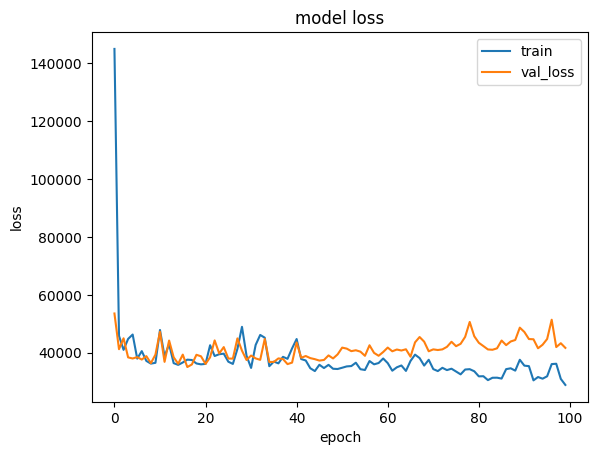

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])
plt.show()

After adding more neurons, we can see that our model has less loss on the data it was trained on

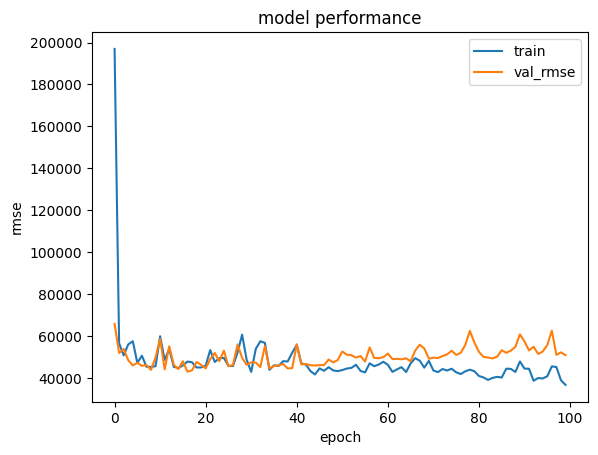

In [25]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model performance')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'val_rmse'])
plt.show()

In [26]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 5ms/step - loss: 42834.1836 - root_mean_squared_error: 53020.5234


[42834.18359375, 53020.5234375]

In [27]:
model.evaluate(X_val, y_val)

4/4 [==============================] - 0s 5ms/step - loss: 41679.8789 - root_mean_squared_error: 51131.0352


[41679.87890625, 51131.03515625]

# Testing our Model

In [28]:
X_test.shape

TensorShape([100, 8])

In [29]:
y_pred = list(model.predict(X_test)[:,0])

4/4 [==============================] - 0s 4ms/step


In [30]:
y_true = list(y_test[:,0].numpy())

In [31]:
model.predict(tf.expand_dims(X_test[0], axis=0))

1/1 [==============================] - 0s 24ms/step


array([[446628.1]], dtype=float32)

In [32]:
y_test[0]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([424305.], dtype=float32)>

# We can see that the predicted value is far from the actual value which tells us that our model is performing poorly

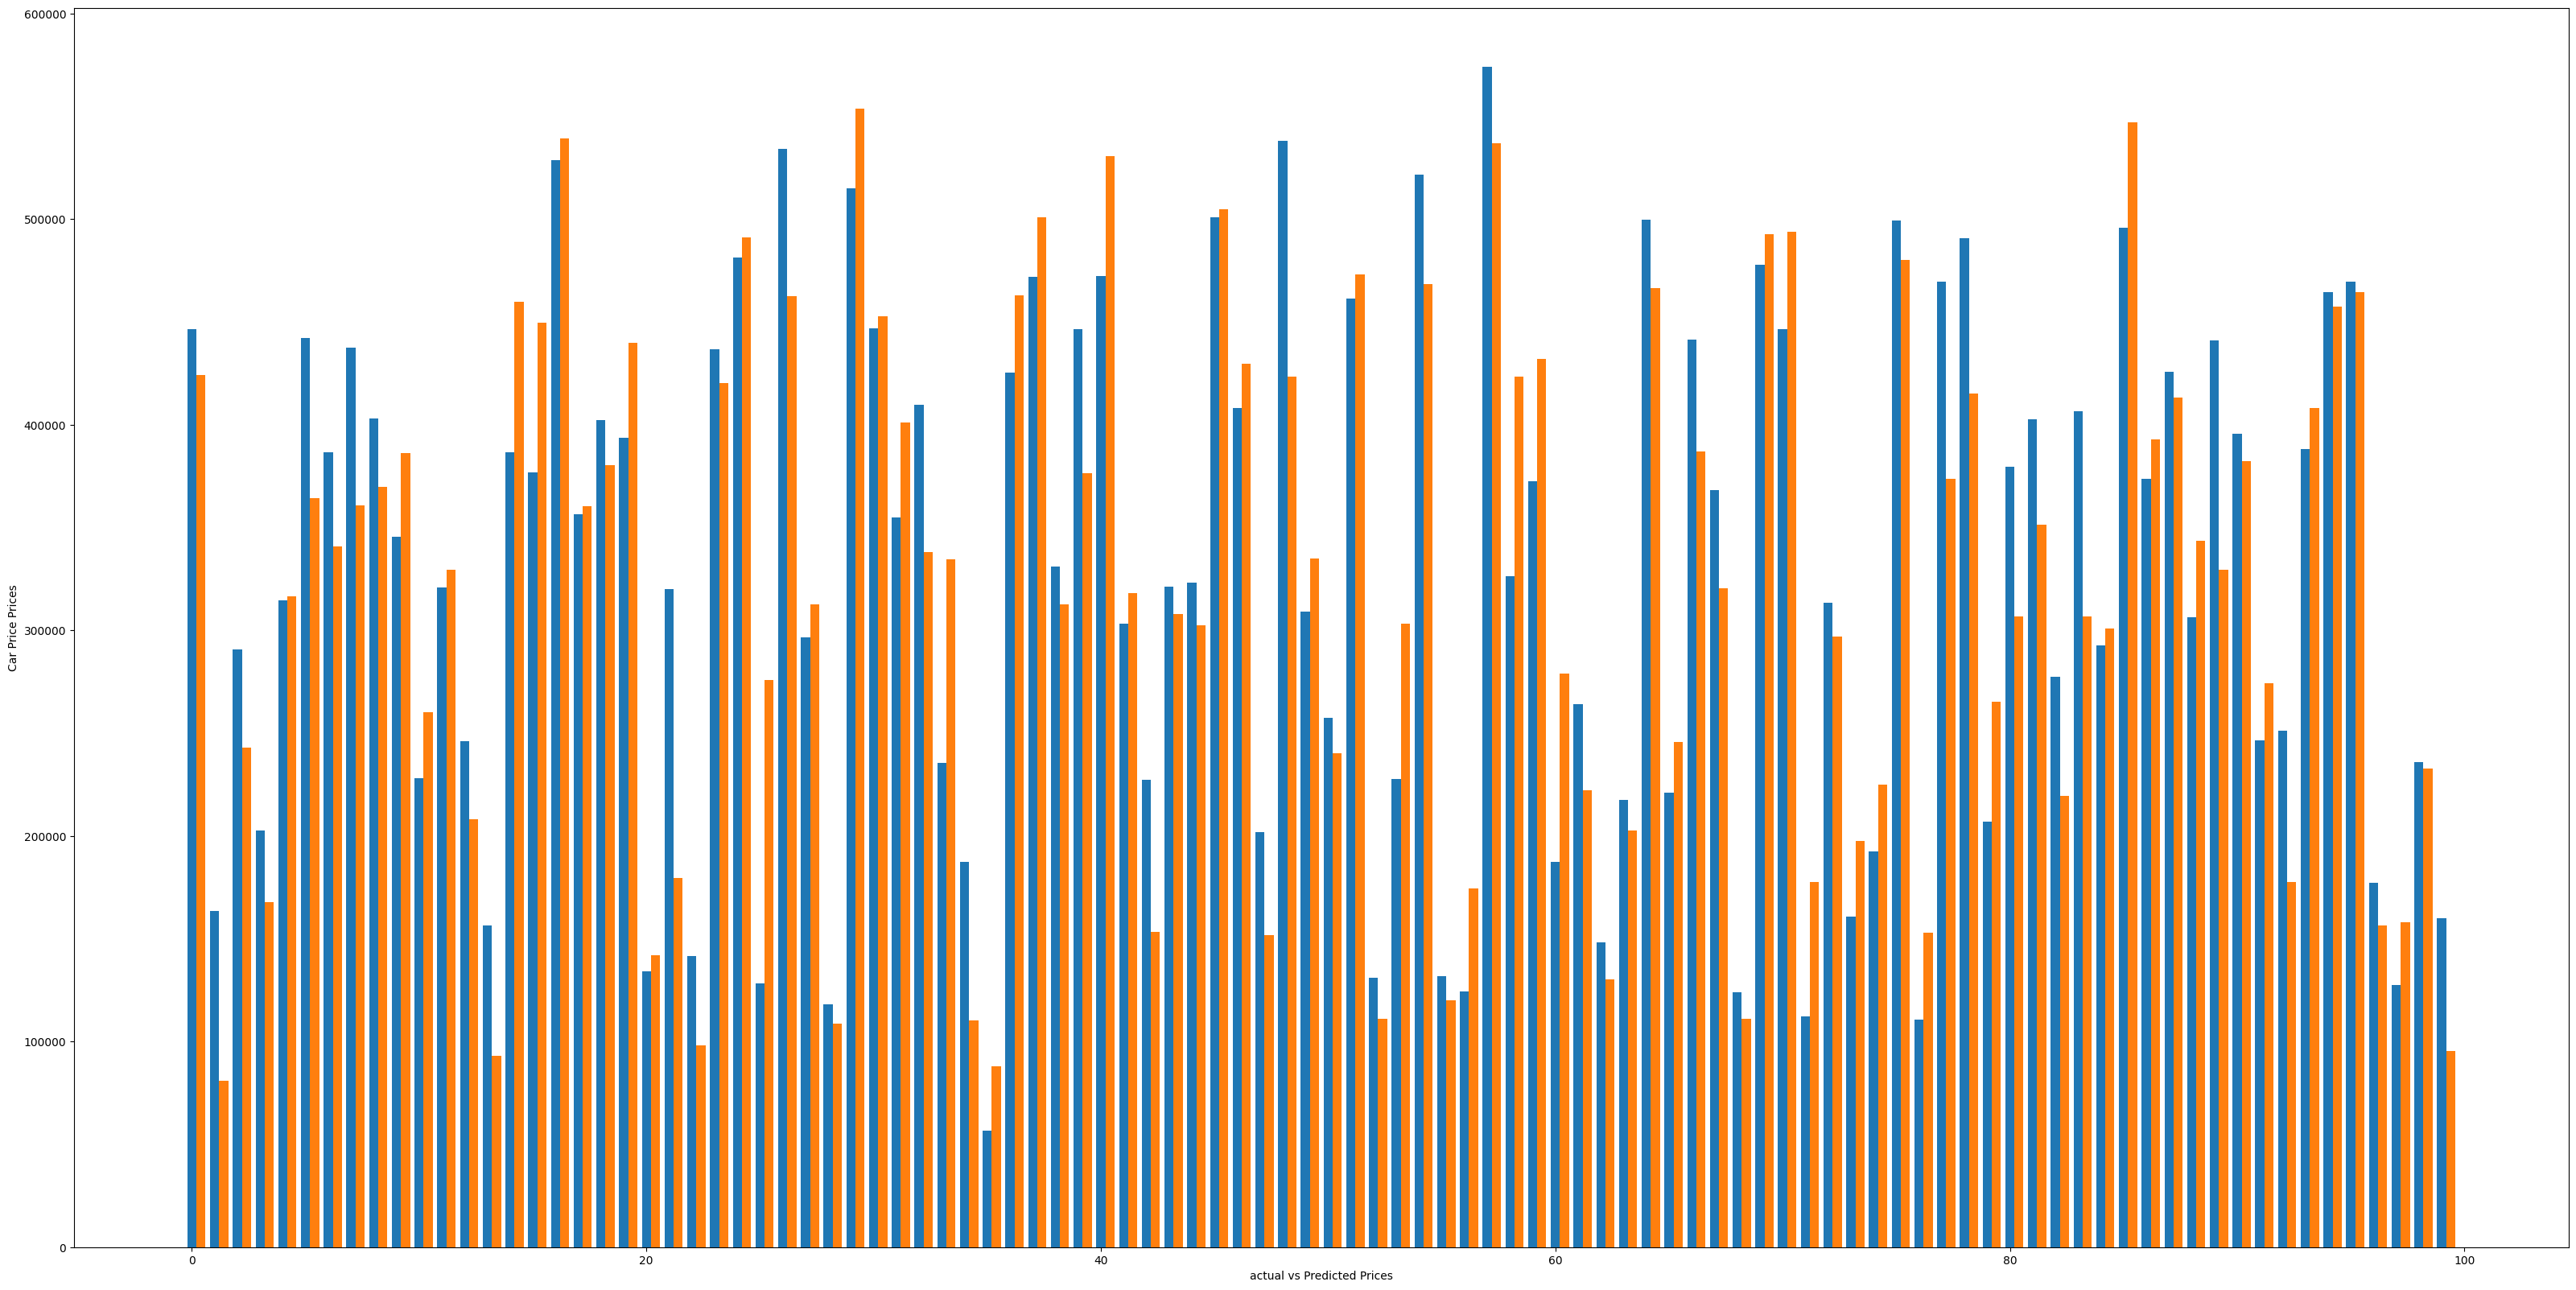

In [33]:
ind = np.arange(100)
plt.figure(figsize=(40,20))

width = 0.4

plt.bar(ind, y_pred, width, label='Predicted Car Price')
plt.bar(ind + width, y_true, width, label ='Actual Car Price')

plt.xlabel("actual vs Predicted Prices")
plt.ylabel("Car Price Prices")

plt.show()

#To solve this problem, we would go back to the top and make our model more complex by adding some more neurons, more dense layers, hidden layers which would lead to the use of an activation function.
# This will make our model perform better and stop under feeding